

> Below code imports all deprendencies which will we required in this model. We will use tensorflow, facenet for FaceNet takes an image of a face as input and outputs the embedding vector.



In [1]:
import os
from os import listdir
from PIL import Image as Img
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
import numpy as np
import tensorflow as tf

import pickle
import cv2

Haar Cascade is a feature-based object detection algorithm to detect objects from images. A cascade function is trained on lots of positive and negative images for detection.

The algorithm does not require extensive computation and can run in real-time. We can train our own cascade function for custom objects like animals, cars, bikes, etc.

Haar Cascade can’t be used for face recognition since it only identifies the matching shape and size.

Haar cascade uses the cascade function and cascading window. It tries to calculate features for every window and classify positive and negative. If the window could be a part of an object, then positive, else, negative.

In [2]:
HaarCascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

FaceNet takes an image of the person's face as input and outputs a vector of 128 numbers which represent the most important features of a face. In machine learning, this vector is called embedding.

In [8]:
pip install keras-facenet

In [9]:
from keras_facenet import FaceNet

In [10]:
MyFaceNet = FaceNet()

In [19]:
""" Here we are taking a folder whch contains some images of Indian celebrities and an empty database in which we will store
      the signatures (i.e 128*128 embedding) of all the celebrities"""

folder='Indian-celebrities/'
database = {}

# Iterating each and every image one by one in folder
for filename in listdir(folder):

    path = folder + filename
    gbr1 = cv2.imread(folder + filename)
    # Here the image is loaded and gbr1 name is given to it then we fed it into haar cascade classifier
    # 1.1 is the magnifying ratio of the image and 4 is the no of pixels to which the bounding box shifts if it finds a face in an image
    framee = HaarCascade.detectMultiScale(gbr1,1.1,4)
    
    # It might be possible that there are more than one face in an image in that case the first detected face is fed
    # In case there is no image then top left corner is given
    if len(framee)>0:
        x1, y1, width, height = framee[0]         
    else:
        x1, y1, width, height = 1, 1, 10, 10
    
    # Here we are calculating the dimensions of bounding box around the face
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # Now we will be feeding this bounding box face into facenet but before doing that
    """ Now we will be using python image library as there are some differences between opencv format and pil format.
      The first challnege is that layer in opencv is not arranged as RGB but BGR which pil uses. So image in gbr1, the
      converted image is called gbr. Here we are converting BGR to RGB and converting the image into an array of size 160*160.
      The reason we are converting this to size of 160*160 is that facenet is trained to received input of 160*160."""
    gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
    gbr = Img.fromarray(gbr)                 
    gbr_array = asarray(gbr)
    
    face = gbr_array[y1:y2, x1:x2]                        
    
    face = Img.fromarray(face)                       
    face = face.resize((160,160))
    face = asarray(face)
    """ Now here we normalise the image as we feed it to facenet. here we area also adding one more dimension because
      we may have more than face in image so we introduce this fourth dimension."""
    
    face = expand_dims(face, axis=0)
    signature = MyFaceNet.embeddings(face)
    
    database[os.path.splitext(filename)[0]]=signature

1/1 [==============================] - 0s 150ms/step


In [13]:
# We are storing our database as pkl file
myfile = open("data.pkl", "wb")
pickle.dump(database, myfile)
myfile.close()

In [14]:
myfile = open("data.pkl", "rb")
database = pickle.load(myfile)
myfile.close()

The below code is for taking the image input from camera.

In [15]:
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

In [16]:
def findFaces(data):
  gbr1 = js_to_image(data)
  gbr = cv2.cvtColor(gbr1, cv2.COLOR_BGR2RGB)
  gbr = Img.fromarray(gbr)                  
  gbr_array = asarray(gbr)
 
  framee = HaarCascade.detectMultiScale(gbr1,1.1,4)
  
  for (x1,y1,w,h) in framee:
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + w, y1 + h
    
      face = gbr_array[y1:y2, x1:x2]                        
    
      face = Img.fromarray(face)                       
      face = face.resize((160,160))
      face = asarray(face)
    
    
      face = expand_dims(face, axis=0)
      signature = MyFaceNet.embeddings(face)
    
      min_dist=100
      identity=' '
      for key, value in database.items() :
        dist = np.linalg.norm(value-signature)
        if dist < min_dist:
          min_dist = dist
          identity = key
            
      cv2.putText(gbr1,identity, (x1,y1),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1, cv2.LINE_AA)
      cv2.rectangle(gbr1,(x1,y1),(x2,y2), (0,255,0), 2)
  
  filename='photo.jpg'
  cv2.imwrite(filename, gbr1)
  
  return filename  

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  
  filename=findFaces(data)

  return filename

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 100ms/step
Saved to photo.jpg


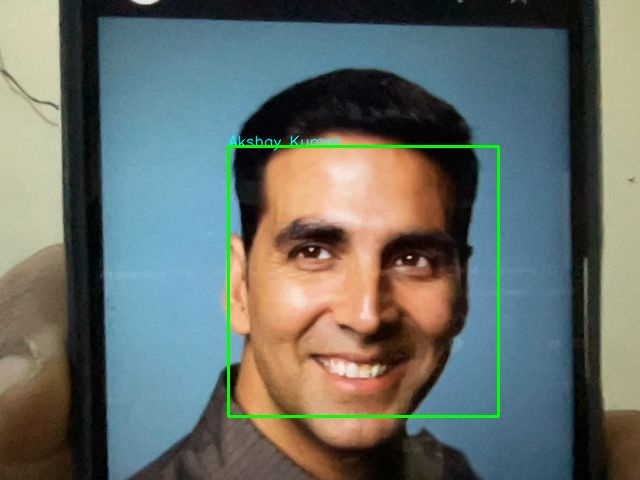

In [18]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
     